# CNN2d_이상행동감지
---
- 8개의 라벨 중 4개 => 0(stand), 1(walk), 3(sit down), 4(lay down) 
- 우선적으로 해보기

In [1]:
# 모듈 로딩
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pickle
from collections import Counter

In [2]:
# 모듈 로딩(2)
import tensorflow as tf
# import logging
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout, Flatten,Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense

***

## 1. **데이터 세트 준비(Data Setup)**

In [3]:
# 로컬에 저장된 iris 데이터 csv 파일을 읽어온다.
# 전체 (train+val) 합쳐진 DataFrame 불러오기
df = pd.read_csv('./bus_getonoff_sum.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983124 entries, 0 to 983123
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   bbox        983124 non-null  object
 1   keypoints   983124 non-null  object
 2   action      983124 non-null  object
 3   get_on      983124 non-null  bool  
 4   get_off     983124 non-null  bool  
 5   get_num     983124 non-null  int64 
 6   action_num  983124 non-null  int64 
dtypes: bool(2), int64(2), object(3)
memory usage: 39.4+ MB


In [5]:
df.action.unique()

array(['stand', 'walk', 'sit down', 'run', 'grab handle', 'lay down',
       'kick', 'punch'], dtype=object)

In [6]:
# 모두 합쳐진 라벨 중, 4개만 추려서 활용할 DataFrame 만들기
df = df.loc[(df.action == 'stand') | (df.action == 'walk')| (df.action == 'sit down')| (df.action == 'lay down')]
# df[df['action']=='stand']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878902 entries, 0 to 983123
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   bbox        878902 non-null  object
 1   keypoints   878902 non-null  object
 2   action      878902 non-null  object
 3   get_on      878902 non-null  bool  
 4   get_off     878902 non-null  bool  
 5   get_num     878902 non-null  int64 
 6   action_num  878902 non-null  int64 
dtypes: bool(2), int64(2), object(3)
memory usage: 41.9+ MB


In [7]:
df.action.value_counts()

sit down    486990
walk        279102
stand       108011
lay down      4799
Name: action, dtype: int64

In [8]:
df.index=range(len(df))
# 인덱스 번호 리셋 확인
# df

### 라벨 csv
---

In [9]:
# i) 전체에서 4개만 떼어내기 -> 진행 완료
# ii) train에서만 4개 떼어내서 붙이기

# i) 전체에서 3개만 떼어내기 -> 
# ii) train에서만 3개 떼어내서 붙이기 

In [10]:
# 모두 합쳐진 라벨 중, 3개만 추려서 활용할 DataFrame 만들기
df1 = df.loc[(df.action == 'stand') | (df.action == 'sit down')| (df.action == 'lay down')]
# df[df['action']=='stand']
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599800 entries, 0 to 878901
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   bbox        599800 non-null  object
 1   keypoints   599800 non-null  object
 2   action      599800 non-null  object
 3   get_on      599800 non-null  bool  
 4   get_off     599800 non-null  bool  
 5   get_num     599800 non-null  int64 
 6   action_num  599800 non-null  int64 
dtypes: bool(2), int64(2), object(3)
memory usage: 28.6+ MB


***

***

## **2. 데이터 전처리(Data Preprocessing)**

In [11]:
df.tail(3)

,bbox,keypoints,action,get_on,get_off,get_num,action_num
878899,"[1177, 288, 1569, 716]","[1446, 632, 1, 1471, 577, 1, 1482, 654, 1, 139...",sit down,False,False,2,3
878900,"[1163, 250, 1488, 716]","[1373, 670, 1, 1372, 585, 1, 1418, 523, 2, 133...",stand,False,False,2,0
878901,"[1145, 161, 1458, 715]","[1331, 670, 1, 1337, 561, 1, 1381, 437, 1, 129...",stand,False,False,2,0


In [12]:
# 문제 데이터와 정답 데이터 나누기
# 1) X => 문제 데이터
# 관절 좌표(keypoints)의 문자열 값을 배열 형태로 변환해야 CNN의 input_shape로 쓸 수 있음
type(df.keypoints[0])

X = []
for i in range(len(df)): # DataFrame의 행의 수만큼 반복
    X.append(np.array(list(map(int,df.keypoints[i].strip('[').strip(']').split(',')))))

# # 배열 형태로 넣기
# df.keypoints = X

In [13]:
# df.keypoints[i].strip('[').strip(']').split(',')

In [14]:
# X를 reshape
X = np.array(list(X)).reshape(-1,16,1,3)

In [15]:
X[0]

array([[[1074, 1020,    2]],

       [[1111,  923,    2]],

       [[1151,  752,    2]],

       [[1266,  829,    2]],

       [[1180, 1012,    2]],

       [[1371, 1077,    0]],

       [[1193,  798,    2]],

       [[1248,  643,    2]],

       [[1334,  462,    2]],

       [[1320,  342,    2]],

       [[1102,  736,    2]],

       [[1148,  649,    2]],

       [[1225,  456,    2]],

       [[1442,  563,    2]],

       [[1407,  763,    2]],

       [[1334,  889,    2]]])

In [16]:
# 2) Y => 정답 데이터
y = np.array(df.action)
y.shape

(878902,)

In [17]:
# 배열 형태로 값들이 저장됨
X.shape

(878902, 16, 1, 3)

In [18]:
# DataFrame 인덱스 번호 문제
# 곧바로 .to_numpy() 해도 nope, 배열안에 배열로 되어 있어야 째서 나눌 수 있음 => [[]] 느낌

In [19]:
len(df)

878902

In [20]:
# 문제 데이터와 정답 데이터 나누기 완료
# -> X(문제 데이터), y(정답 데이터)

In [21]:
# # 스케일링 (해봤지만 큰 차이x)
# x_train = x_train/255.0
# x_test = x_test/255.0

In [22]:
# LabelEncoder나 One-hot Coding 중 할 것이 있는가?
# -> 이미 'action_num'으로 나누어 놓은 컬럼을 썼기 때문에 굳이 해줄 필요 없음
# LabelEncoder를 이용해서 'stand', 'walk', 'sit down', 'lay down'를 각각 0~3의 숫자형 레이블로 변환

# 레이블 데이터
input_labels = ['stand', 'walk', 'sit down', 'lay down']

# 레이블 인코더 객체 생성
label_encoder = LabelEncoder()

# 레이블 학습
y = label_encoder.fit_transform(y)

In [23]:
# 라벨 확인
for i, label in enumerate(label_encoder.classes_):
    print(i, '->', label)

0 -> lay down
1 -> sit down
2 -> stand
3 -> walk


In [24]:
# 숫자를 문자로 변환, 디코딩
encode_datas = [1, 3, 2]
print(encode_datas, '->', label_encoder.inverse_transform(encode_datas))

[1, 3, 2] -> ['sit down' 'walk' 'stand']


In [25]:
# 과적합 방지를 위한 데이터 셋 분리
# suffle : CNN의 경우, LSTM처럼 시계열성을 굳이 가질 필요가 없다고 판단 (False로 하지 않아도 될 듯함, 디폴트 값이 True)
# - 여부에 따라 다른지 차후 한번 해보기
# stratify : 
# - 앞에서 인코딩을 안해서 그런지
# - 모집단의 데이터 분포를 유지하는 것이 맞을 것이므로
# - 현재 많이 나오는 컬럼만 (stand, walk, sit down, lay down) 들어간 상태니까
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [26]:
# # 추론을 위한 데이터 저장.
# with open(os.path.join('meta_data/label_encoder.p'), 'wb') as f:
#     pickle.dump(label_encoder, f) 

## 3.모델 설계 및 훈련

In [27]:
# from keras.callbacks import EarlyStopping
# EarlyStopping(val_loss 5회 이상 개선 없을시 멈춘다.)
# monitor : 모니터링할 성능
# mode : 모니터링할 성능을 최소화(min), 최대화(max)시킬 것인지 지정 
# - keras에서 알아서 적절한 epoch에서 training을 멈춤
# patience : 성능이 증가하지 않는 epoch를 몇 번이나 허용할 것인가를 정의
# - 성능의 증가하지 않는다고, 그 순간 바로 멈추는 것은 효과적이지 않을 수도 있으므로

patience = 5
stopCB = EarlyStopping(monitor='val_loss', mode='min', patience=patience)


In [28]:
# ModelCheckpoint : 모델이 학습하면서 정의한 조건을 만족했을 때 Model의 weight 값을 중간 저장.
# => from keras.callbacks import ModelCheckpoint

MODEL_DIR = './model/'               # 모델 저장 폴더
if not os.path.exists(MODEL_DIR):    # 해당 폴더 존재하지 않을 경우
    os.mkdir(MODEL_DIR)              # 해당 폴더 만들기
    
modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5' # epoch-val_loss 이름으로 저장

mc = ModelCheckpoint(filepath=modelpath,  # file명 지정
                     monitor ='val_loss', # val_loss 값이 개선 되었을때 호출
                     verbose=1,           # 로그 출력 
                     save_best_only=True) # val_loss best 값 저장

# Earlystopping 을 하는 것은 특정 시점에 모델의 트레이닝을 멈춤으로써,
# 모델의 validation error 가 더 이상 낮아지지 않도록 조절할 수는 있겠지만,
# 중지된 상태가 최고의 모델은 아님
# => 가장 validation performance 가 좋은 모델을 저장하는 것이 필요
# => ModelCheckpoint 라고 하는 객체가 keras에서는 존재

# ========================================================================
# validation error 를 모니터링하면서,
# 이전 epoch 에 비해 validation performance 가 좋은 경우,
# 무조건 이 때의 parameter 들을 저장한다. 이를 통해 트레이닝이 중지되었을 때
# 가장 validation performance 가 높았던 모델을 반환할 수 있다. 
# ========================================================================

In [29]:
# 합성곱 신경망 구성하기
# 굳이 MaxPooling2D를 해야 하는지 여부에 대해서는 여부로 실험해볼 것
# BatchNormalization()의 필요성은?
# - 학습/추론 단계의 배치 정규화는 달라야 함 => 여기선 학습에서 쓰는 배치 정규화에 따름
# - batch normalization은 activation function 앞에 적용
# - Normalization 과정을 통하여, 모든 계층의 Feature가 동일한 Scale이 되어
# - learning rate 결정에 유리한 효과를 가지게 되고 추가적인 Scale, Bias를 학습하여 Activation에 적합한 분포로 변환 가능
# 합성곱(Convolution) -> 특성(Feature) -> 배치 정규화(BatchNormalization) - 활성화 함수(activation function) 순서로 적용
# https://gaussian37.github.io/dl-concept-batchnorm/#batch-normalization-1

# =======================================================

model = Sequential()          
model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', input_shape=(16,1,3)))
model.add(MaxPooling2D(pool_size = (2,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))


In [30]:
# Flatten (펴주기) & Dense층 추가하기
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [31]:
# model 컴파일
# - compile() 메서드를 이용해서 옵티마이저, 손실 함수, 지표를 각각 설정
# - 다중 클래스 범주 -> i) 원-핫 벡터 형태(categorical_crossentropy), ii) 정수 형태(sparse_categorical_crossentropy)
# -> 둘 다 정확도에는 영향을 미치지는 않지만, sparse~가 메모리 소요가 적다고 함

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 1, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 1, 32)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 1, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 1, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 1, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 1, 64)         0

C:\Users\ahasu\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
# # 6. 훈련하기
# model.fit(X_train, y_train, epochs=5)

In [33]:
# from tensorflow.keras.callbacks import EarlyStopping
# # 검증 데이터에 대한 loss값 3번 연속 개선되지 않으면 학습 중지
# stopCB = EarlyStopping(monitor='val_loss', patience=3)

# # 6. 훈련하기
# model.fit(X_train, y_train, epochs=5)

with tf.device("/device:GPU:0"):
    # model.fit(X_train, y_train, epochs=10)
    hist = model.fit(X_train, y_train, epochs=10,
                    batch_size = 10,
                    validation_split=0.2,
                    callbacks=[stopCB, mc])
    
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.legend(['training', 'validation'], loc = 'upper left')
    # plt.show()

Epoch 1/10
56250/56250 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8571
Epoch 1: val_loss improved from inf to 0.35253, saving model to ./model\01-0.3525.hdf5
56250/56250 [==============================] - 273s 5ms/step - loss: 0.3732 - accuracy: 0.8571 - val_loss: 0.3525 - val_accuracy: 0.8643
Epoch 2/10
56244/56250 [============================>.] - ETA: 0s - loss: 0.3313 - accuracy: 0.8746
Epoch 2: val_loss improved from 0.35253 to 0.32153, saving model to ./model\02-0.3215.hdf5
56250/56250 [==============================] - 262s 5ms/step - loss: 0.3313 - accuracy: 0.8746 - val_loss: 0.3215 - val_accuracy: 0.8756
Epoch 3/10
56239/56250 [============================>.] - ETA: 0s - loss: 0.3199 - accuracy: 0.8789
Epoch 3: val_loss did not improve from 0.32153
56250/56250 [==============================] - 257s 5ms/step - loss: 0.3199 - accuracy: 0.8789 - val_loss: 0.3457 - val_accuracy: 0.8726
Epoch 4/10
56246/56250 [============================>.] - ETA: 0

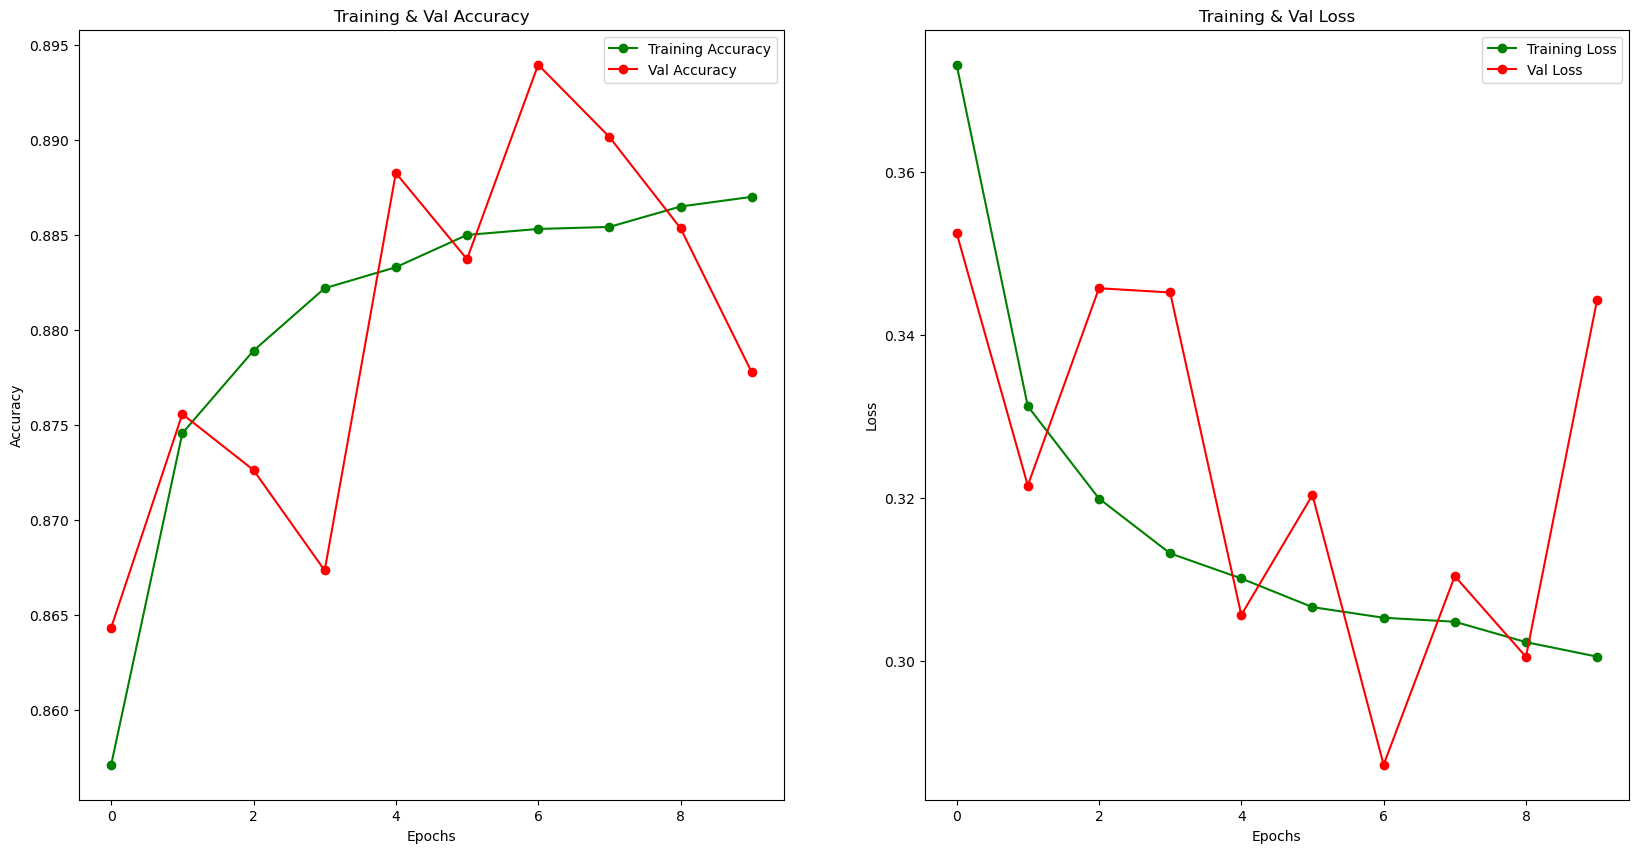

In [34]:
    # epoch 마다 train, validation의 accuracy, loss 시각화
    epochs = hist.epoch
    fig , ax = plt.subplots(1,2)
    train_acc = hist.history['accuracy']
    train_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    fig.set_size_inches(20,10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Val Accuracy')
    ax[0].set_title('Training & Val Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Val Loss')
    ax[1].set_title('Training & Val Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()

In [35]:
# 모델을 평가한다
model.evaluate(X_test,y_test)

5494/5494 [==============================] - 13s 2ms/step - loss: 0.3782 - accuracy: 0.8770


[0.378210186958313, 0.8770231008529663]

## 4. 모델 추론(Inference)

In [163]:
# np.argmax : 가장 높은 값의 인덱스 반환
(np.argmax(model.predict(X_test), axis=1))

5494/5494 [==============================] - 7s 1ms/step


array([1, 1, 1, ..., 3, 1, 1], dtype=int64)

In [164]:
# 숫자형 레이블을 다시 문자형으로 변환
label_encoder.inverse_transform(np.argmax(model.predict(X_test),axis=1))

5494/5494 [==============================] - 7s 1ms/step


array(['sit down', 'sit down', 'sit down', ..., 'walk', 'sit down',
       'sit down'], dtype=object)

In [165]:
# 라벨 확인
for i, label in enumerate(label_encoder.classes_):
    print(i, '->', label)

0 -> lay down
1 -> sit down
2 -> stand
3 -> walk


***

In [ ]:
# 혼동행렬 시각화 (8개의 라벨에서 썼으면 됐을 듯)
# - 현재는 필요한 라벨만 딱 뺀 상태이기 때문에

## **4. 추론 (Inference)**

훈련시킨 모델을 직접 사용해보고자 한다. 잘 훈련된 모델이라면 버스 승객의 승하차 영상을 입력 데이터로 주었을 때, 승하차 여부를 결과값으로 모델이 내보낼 것이다. 그 과정을 진행해보고자 한다.

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [3]:
hub_model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = hub_model.signatures['serving_default']

In [ ]:
# cv2.VideoCapture() : 비디오 캡쳐 객체를 생성
# - 안의 숫자는 장치 인덱스(어떤 카메라를 사용할 것인가)
# - 1개만 부착되어 있으면 0, 2개 이상이면 첫 웹캠은 0, 두번째 웹캠은 1으로 지정
# - 영상 파일이라면 경로 입력

# cap.isOpen() : 비디오 캡쳐 객체가 정상적으로 Open되었는지 확인합니다

# ret, fram = cap.read() : 비디오의 한 프레임씩 읽음
# - ret : 제대로 프레임을 읽으면 ret값이 True, 실패하면 False가 나타남
# - fram : 읽은 프레임이 나옵니다


In [1]:
# main - 승하차
# sub - 이상행동
cap = cv2.VideoCapture('./hcb_part/lay_down(1).mp4')

get_state = ['lay down', 'sit down', 'stand', 'walk']

while cap.isOpened():
    ret, frame = cap.read()
    point_list = []
    
    if (ret): # frame capture 결과
        # frame = cv2.flip(frame,0) # 영상 뒤집혀서 출력되는 경우 사용
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 192, 256)
        input_img = tf.cast(img, dtype=tf.int32)

        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6, 17, 3))

        loop_through_people(frame, keypoints_with_scores, EDGES, 0.2)

        # load model
        model = load_model('./model/07-0.2939.hdf5')

        for point in point_list:
            if len(point) == 17: # keypoints가 다 잡혔을 때 결과값 예측
                # train model에 들어간 keypoints랑 movenet에 검출되는 keypoints 순서가 달라서 변환
                switch = [point[16], point[14], point[12], point[11], point[13], point[15], point[4], point[0], point[2], point[1],
                        point[10], point[8], point[6], point[5], point[7], point[9]]
                result = model.predict(np.array(switch).reshape(-1,16,1,3))
                cv2.putText(frame, get_state[result.argmax()], (point[0][0]-100, point[0][1]-100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, lineType=cv2.LINE_AA)
                print(get_state[result.argmax()])
        cv2.imshow('', frame)
            
        if cv2.waitKey(1) & 0xFF==ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [4]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [5]:
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_lines(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [6]:
def draw_lines(frame, keypoints, edges, confidence_threshold):
    y, x, _ = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, _ in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

In [7]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, _ = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    i = 0
    points = []

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0, 255, 0), -1)
            
            if i == 0:
                point_list.append(points)
            points.append((int(kx), int(ky), 0))
            i += 1

***

## 정답률 확인

In [36]:
ppp = np.argmax(model.predict(X_test),axis=1)

5494/5494 [==============================] - 8s 1ms/step


In [37]:
ppp = ppp.tolist()
type(ppp)

list

In [38]:
# (stand, walk, sit down, lay down)

In [39]:
y_test.tolist()

[1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 3,
 3,
 3,
 2,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 3,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 1,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 2,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 2,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 3,
 2,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 3,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 3,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 3,
 3,
 1,
 2,
 1,
 3,
 3,
 1,
 1,
 2,
 3,
 3,
 3,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 2,
 1,
 1,
 2,
 3,
 2,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,


In [40]:
oo = 0
xx = 0
for i in range(len(ppp)):
    if ppp[i] == y_test[i]:
        oo += 1
    else:1
        xx += 1
print(f'맞은 개수 : {oo}개, 틀린 개수 : {xx}개, 정답률 : {round((oo/(oo+xx))*100,2)}%')

맞은 개수 : 154164개, 틀린 개수 : 21617개, 정답률 : 87.7%


***